In [58]:
import pandas as pd
from numpy import nan
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [59]:
eur_bonds = pd.read_excel("Europe_Green_Bonds_Issued.xlsx", sheet_name="Bonds_Values" )

In [60]:
# Add a column to also include the amount in Euros
# Since we know that stellantis has exactly 500M Euros, we will use this as a reference for our conversion
# Stellantis is the first row, and the amount out is the 11th indexed column
usd_per_eur = eur_bonds.iloc[0, 11]/500000000
usd_per_eur

1.08635

In [61]:
eur_bonds['Amt Issued (EUR)'] = eur_bonds['Amt Issued (USD)']/usd_per_eur
eur_bonds['Amt Out (EUR)'] = eur_bonds['Amt Out (USD)']/usd_per_eur

In [62]:
# Rearrange so the amounts are next to each other
var_list = ['Amt Out (EUR)', 'Amt Issued (EUR)', 'Amt Out (USD)', 'Amt Issued (USD)']
column_list = []

for var in var_list:
    column_list.append(eur_bonds.pop(var))

for idx, var in enumerate(var_list):
    eur_bonds.insert(11, var, column_list[idx])

In [63]:
# Replace the fields that did not load from bloomberg with at np.nan
eur_bonds.replace(to_replace="#N/A Field Not Applicable", value=nan, inplace=True)

In [64]:
eur_bonds.head()

,Issuer Name,Ticker,Moody Rtg,BBG Composite,Cntry of Incorp,Country/Region (Full Name),Maturity,Mty Type,Series,Currency,Cpn,Amt Issued (USD),Amt Out (USD),Amt Issued (EUR),Amt Out (EUR),ECBC Covered,Labeled Instrument Debut
0,Stellantis NV,STLA,Baa1,BBB+,NL,NETHERLANDS,2036-03-19,CALLABLE,EMTn,EUR,3.750,5.431750e+08,5.431750e+08,5.000000e+08,5.000000e+08,N,N
1,TenneT Holding BV,TENN,Baa3,BB+,NL,NETHERLANDS,NaN,PERP/CALL,NaN,EUR,4.875,5.971845e+08,5.971845e+08,5.497165e+08,5.497165e+08,N,N
2,Iceland Government International Bond,ICELND,A2,A,IS,ICELAND,2034-03-21,AT MATURITY,NaN,EUR,3.500,8.143425e+08,8.143425e+08,7.496134e+08,7.496134e+08,N,Y
3,E.ON SE,EOANGR,Baa2,BBB+,DE,GERMANY,2044-03-25,CALLABLE,EMTN,EUR,4.125,1.083650e+09,1.083650e+09,9.975146e+08,9.975146e+08,N,N
4,TenneT Holding BV,TENN,Baa3,BB+,NL,NETHERLANDS,NaN,PERP/CALL,*,EUR,4.625,5.971845e+08,5.971845e+08,5.497165e+08,5.497165e+08,N,N


### First we will take a look at the total amount of bonds issued and outstanding per country, without removing unlabelled bonds

<Axes: xlabel='Country/Region (Full Name)'>

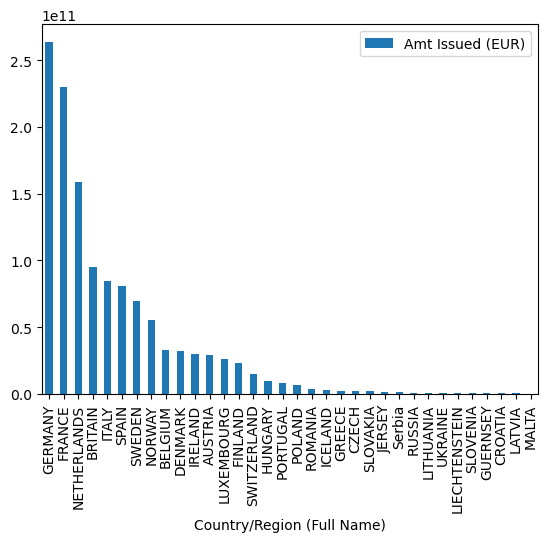

In [65]:
eur_bonds.groupby("Country/Region (Full Name)")[['Amt Issued (EUR)']].sum().sort_values('Amt Issued (EUR)', ascending=False).plot(kind='bar')

In [66]:
bonds_labelled = eur_bonds.groupby(["Labeled Instrument Debut"])[['Amt Issued (EUR)']].sum()
bonds_labelled

,Amt Issued (EUR)
Labeled Instrument Debut,
N,8.791603e+11
Y,3.892020e+11


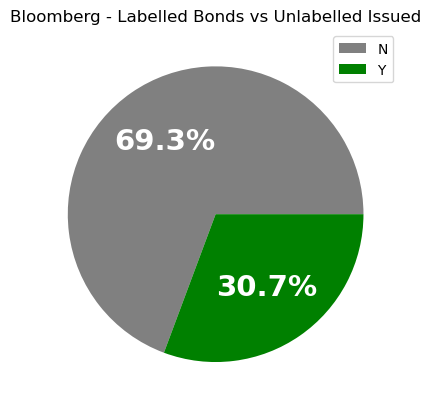

In [67]:
# Plotting pie chart
colors = ['grey', 'green'] 
textprops = {'color': 'white', 'weight': 'bold', 'fontsize': 21}

plt.pie(bonds_labelled['Amt Issued (EUR)'], labels=bonds_labelled.index, colors=colors, autopct='%1.1f%%', textprops=textprops)
plt.title('Bloomberg - Labelled Bonds vs Unlabelled Issued')
plt.legend()
plt.show()

In [68]:
# Now the same thing but seperate the labelled bonds from the unlabelled ones using the Labeled instrument debut
country_bonds_labelled = eur_bonds.groupby(["Country/Region (Full Name)", "Labeled Instrument Debut"], as_index=False)[['Amt Issued (EUR)']].sum()

In [69]:
# Split into two and then join them (Pivot the data)
columns = ['Country/Region (Full Name)', 'Amt Issued (EUR)']
country_bonds_labelled_Y = country_bonds_labelled[country_bonds_labelled['Labeled Instrument Debut'] == "Y"][columns]
country_bonds_labelled_N = country_bonds_labelled[country_bonds_labelled['Labeled Instrument Debut'] == "N"][columns]

country_bonds = country_bonds_labelled_Y.merge(
    country_bonds_labelled_N,
    on = 'Country/Region (Full Name)',
    suffixes=(' Labelled', ' Unlabelled'),
    how='outer'
)

country_bonds.fillna(0, inplace=True)
country_bonds.sort_values(
    by='Amt Issued (EUR) Labelled', 
    key=country_bonds['Amt Issued (EUR) Unlabelled'].add, 
    ascending=False, 
    inplace=True
)

country_bonds.reset_index(drop=True, inplace=True)

In [149]:
country_bonds['Country/Region (Full Name)'] = country_bonds['Country/Region (Full Name)'].str.title()

In [151]:
country_bonds.to_csv("Sustainable_Bonds_By_Country.csv", index=False)

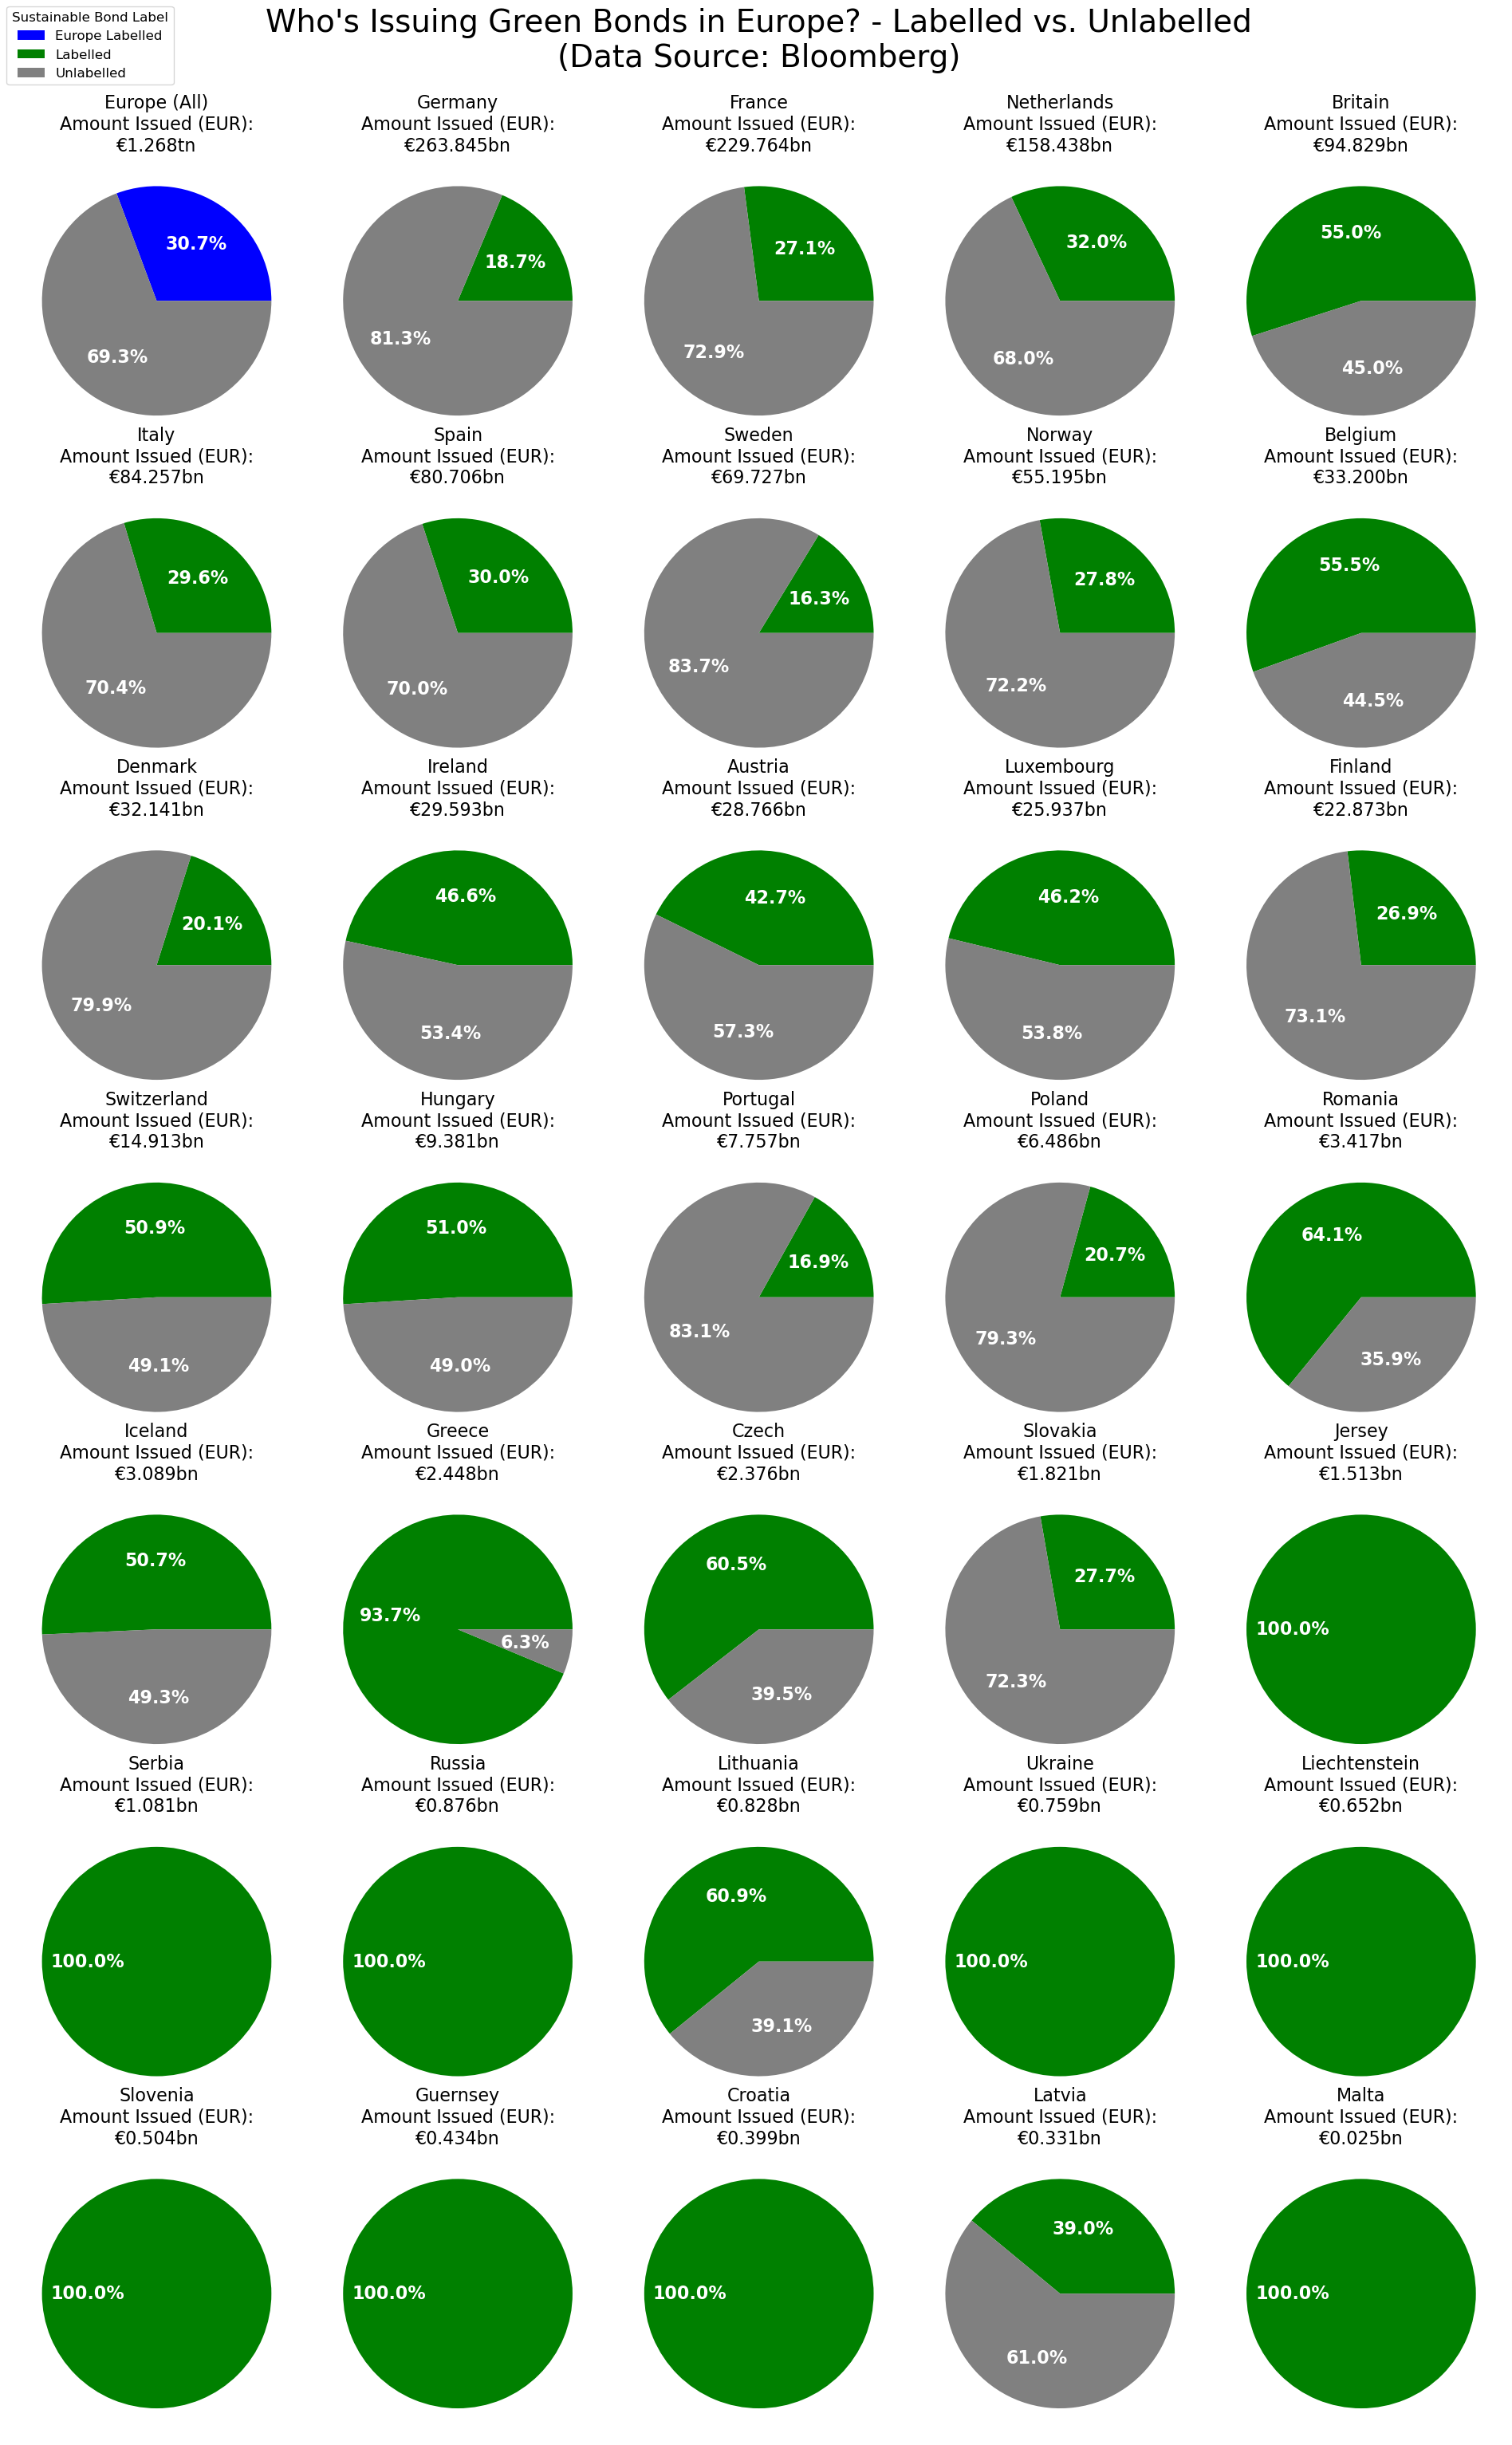

In [145]:
plt.figure(figsize=(19, 30.8))

width = 7
height = 5

# Add the total first, with blue as the colour
plt.subplot(width, height, 1)

plt.pie(
        [
            country_bonds['Amt Issued (EUR) Labelled'].sum(),
            country_bonds['Amt Issued (EUR) Unlabelled'].sum()
        ], 
        colors=['blue', 'grey'],
        # Adds the percentages, empty string if no issuance for that label 
        autopct=lambda p: '{:.1f}%'.format(round(p, 1)) if p > 0 else '',
        textprops={'color': 'white', 'weight': 'bold', 'fontsize': 16}
)

total_amt_issued_trillions = \
    (
        country_bonds['Amt Issued (EUR) Labelled'].sum() +\
        country_bonds['Amt Issued (EUR) Unlabelled'].sum() 
    ) / 10**12

plt.title(f'Europe (All)\nAmount Issued (EUR):\n€{total_amt_issued_trillions:.3f}tn', fontsize=16)

for i, row in country_bonds.iterrows():
    country = row['Country/Region (Full Name)']
    yes_amt = row['Amt Issued (EUR) Labelled']
    no_amt = row['Amt Issued (EUR) Unlabelled']
    total_amt_issued_billions = (yes_amt + no_amt) / 10**9
    
    # Prepare data for pie chart
    sizes = [yes_amt, no_amt]
    colors = ['green', 'grey']
    
    plt.subplot(width, height, i+2)
    
    plt.pie(
        sizes, 
        colors=colors,
        # Adds the percentages, empty string if no issuance for that label 
        autopct=lambda p: '{:.1f}%'.format(round(p, 1)) if p > 0 else '',
        textprops={'color': 'white', 'weight': 'bold', 'fontsize': 16}
    )
    
    plt.title(f'{country.title()}\nAmount Issued (EUR):\n€{total_amt_issued_billions:.3f}bn', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.945, hspace=0.05, wspace=0.05)
plt.suptitle("Who's Issuing Green Bonds in Europe? - Labelled vs. Unlabelled\n(Data Source: Bloomberg)", fontsize = 28, y=1)

# Adding a legend for the colors
legend_elements = [
    Patch(facecolor='blue', label='Europe Labelled'),
    Patch(facecolor='green', label='Labelled'), 
    Patch(facecolor='grey', label='Unlabelled')
]

plt.figlegend(handles=legend_elements, loc='upper left', title="Sustainable Bond Label", fontsize=12, title_fontsize=12)

plt.show()